In [27]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression as LR

In [93]:
dems = pd.read_csv('../datasets/dem_candidates.csv')

In [94]:
dems = dems.rename(columns={'Warren Endorsed? ': 'Warren Endorsed?', 'Guns Sense Candidate?': 'Gun Sense Candidate?'})
endorsement_cols = dems.columns[pd.Series(dems.columns).str.contains('Endorsed')].values
endorsement_cols = np.append(endorsement_cols, 'Gun Sense Candidate?')
endorsement_cols = np.append(endorsement_cols, 'Party Support?')
# endorsement_cols = np.append(endorsement_cols, 'Obama Alum?')
# endorsement_cols = np.append(endorsement_cols, 'No Labels Support?')
dems[endorsement_cols] = dems[endorsement_cols].replace({'No': 0, 'Yes': 1})
dems['Total Endorsements'] = dems[endorsement_cols].sum(axis=1)
dems['Endorsed'] = (dems['Total Endorsements'] > 0).astype(int)
dems['Won_int'] = (dems['Won Primary'] == 'Yes').astype(int)
dems['Race'] = (dems['Race'] == 'Nonwhite').astype(int)
dems['Veteran?'] = (dems['Veteran?'] == 'Yes').astype(int)
dems['LGBTQ?'] = (dems['LGBTQ?'] == 'Yes').astype(int)
dems['Self-Funder?'] = (dems['Self-Funder?'] == 'Yes').astype(int)
dems['STEM?'] = (dems['STEM?'] == 'Yes').astype(int)

In [95]:
dems.head()

Candidate State             District Office Type Race Type  \
0  Anthony White (Alabama)    AL  Governor of Alabama    Governor   Regular   
1   Christopher Countryman    AL  Governor of Alabama    Governor   Regular   
2    Doug "New Blue" Smith    AL  Governor of Alabama    Governor   Regular   
3          James C. Fields    AL  Governor of Alabama    Governor   Regular   
4            Sue Bell Cobb    AL  Governor of Alabama    Governor   Regular   

  Race Primary Election Date Primary Status Primary Runoff Status  \
0                     6/5/18           Lost                  None   
1                     6/5/18           Lost                  None   
2                     6/5/18           Lost                  None   
3                     6/5/18           Lost                  None   
4                     6/5/18           Lost                  None   

  General Status  Partisan Lean  ...  Our Revolution Endorsed?  \
0           None     -28.879999  ...                       NaN   
1           None     -28.879999  ...                       NaN   
2           None     -28.879999  ...                       NaN   
3           None     -28.879999  ...                       NaN   
4           None     -28.879999  ...                       NaN   

  Justice Dems Endorsed?  PCCC Endorsed?  Indivisible Endorsed?  \
0                    NaN             NaN                    NaN   
1                    NaN             NaN                    NaN   
2                    NaN             NaN                    NaN   
3                    NaN             NaN                    NaN   
4                    NaN             NaN                    NaN   

   WFP Endorsed? VoteVets Endorsed?  No Labels Support?  Total Endorsements  \
0            NaN                NaN                 NaN                 0.0   
1            NaN                NaN                 NaN                 0.0   
2            NaN                NaN                 NaN                 0.0   
3            NaN                NaN                 NaN                 0.0   
4            NaN                NaN                 NaN                 0.0   

  Endorsed  Won_int  
0        0        0  
1        0        0  
2        0        0  
3        0        0  
4        0        0  

[5 rows x 35 columns]

In [96]:
dems.columns

Index(['Candidate', 'State', 'District', 'Office Type', 'Race Type',
       'Race Primary Election Date', 'Primary Status', 'Primary Runoff Status',
       'General Status', 'Partisan Lean', 'Primary %', 'Won Primary', 'Race',
       'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?',
       'Obama Alum?', 'Party Support?', 'Emily Endorsed?',
       'Gun Sense Candidate?', 'Biden Endorsed?', 'Warren Endorsed?',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
       'Total Endorsements', 'Endorsed', 'Won_int'],
      dtype='object')

Justice Dems (50), Our Revolution (85), WFP (30), Indivisible (46), VoteVets (28), Emily (54), PCCC (15), Party (39), Gun Sense (193)

In [97]:
endorsement_cols

array(['Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed?',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?',
       'Gun Sense Candidate?', 'Party Support?'], dtype=object)

## Inverse Propensity Weighting: Our Revolution

- Y (outcome): `'Won Primary'` as `'Won_int'`
- Z (treatment): `'Our Revolution Endorsed?'`
- X (confounders): `'Total Endorsements'` other than Our Revolution, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'Self-Funder?'`, `'STEM?'`

In [138]:
our_rev = dems[dems['Our Revolution Endorsed?'].notnull() == True][['Won_int', 'Our Revolution Endorsed?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'Self-Funder?', 'STEM?']].reset_index().drop(columns=['index'])
our_rev.head()

Won_int  Our Revolution Endorsed?  Total Endorsements  Partisan Lean  Race  \
0        0                       1.0                 2.0     -24.559999     0   
1        1                       0.0                 0.0     -24.559999     1   
2        0                       0.0                 0.0      25.830000     1   
3        0                       0.0                 0.0      25.830000     0   
4        0                       0.0                 0.0      25.830000     1   

   Veteran?  LGBTQ?  Self-Funder?  STEM?  
0         0       1             0      0  
1         0       0             0      1  
2         0       0             0      1  
3         1       0             0      0  
4         0       0             0      0

In [139]:
# creating our treatment, outcome, and confounder arrays
Z = our_rev['Our Revolution Endorsed?'].values
Y = our_rev['Won_int'].values
X = our_rev.drop(['Our Revolution Endorsed?', 'Won_int'], axis=1).to_numpy()

In [140]:
# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

In [141]:
# function for estimating treatment effect
def estimate_treatment_effect(model, X, Y, Z):
    return np.mean((Z * Y / model.predict_proba(X)[:, 1]) - ((1 - Z) * Y / model.predict_proba(X)[:, 0]))

In [142]:
estimate_treatment_effect(fit, X, Y, Z)

-0.2551258588659646

Since this is a negative number, the treatment (being endorsed by `Our Revolution`) caused the probability of winning to decrease.

In [143]:
# naive estimator from HW4, not sure if we need for this
# the naive estimator does not account for confounders!
# Interesting... once we control for confounders, we observe the opposite effect (positive to negative)
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.0991596638655462

### Adding the propensity scores

In [144]:
our_rev['pscore'] = fit.predict_proba(X)[:, 1]
our_rev.head()

Won_int  Our Revolution Endorsed?  Total Endorsements  Partisan Lean  Race  \
0        0                       1.0                 2.0     -24.559999     0   
1        1                       0.0                 0.0     -24.559999     1   
2        0                       0.0                 0.0      25.830000     1   
3        0                       0.0                 0.0      25.830000     0   
4        0                       0.0                 0.0      25.830000     1   

   Veteran?  LGBTQ?  Self-Funder?  STEM?    pscore  
0         0       1             0      0  0.494445  
1         0       0             0      1  0.057067  
2         0       0             0      1  0.012697  
3         1       0             0      0  0.003617  
4         0       0             0      0  0.015998

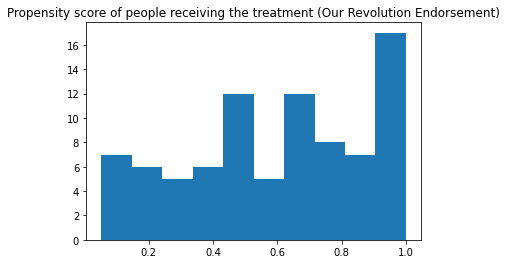

In [145]:
plt.hist(our_rev[our_rev['Our Revolution Endorsed?'] == 1]['pscore']);
plt.title("Propensity score of people receiving the treatment (Our Revolution Endorsement)");

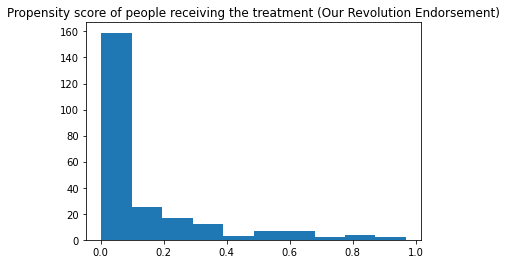

In [146]:
plt.hist(our_rev[our_rev['Our Revolution Endorsed?'] == 0]['pscore']);
plt.title("Propensity score of people receiving the treatment (Our Revolution Endorsement)");

### IPW Estimate

In [147]:
reweighted_treated = (our_rev[our_rev['Our Revolution Endorsed?'] == 1]['Won_int'] / our_rev[our_rev['Our Revolution Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (our_rev[our_rev['Our Revolution Endorsed?'] == 0]['Won_int'] / (1 - our_rev[our_rev['Our Revolution Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(our_rev)
ipw_estimate

-0.25512585886596467

In [148]:
obs_filt = our_rev[our_rev['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (our_rev[our_rev['Our Revolution Endorsed?'] == 1]['Won_int'] / obs_filt[obs_filt['Our Revolution Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Our Revolution Endorsed?'] == 0]['Won_int'] / (1 - obs_filt[obs_filt['Our Revolution Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(our_rev)
trimmed_ipw_estimate

-0.10448229346028487

## Inverse Propensity Weighting: Party Support